<!-- dom:TITLE: Automatic for the people -->
# Automatic for the people

**MOD510: Project 1**  

**Deadline: 15. September 2024 (23:59)**

Date: **Sept. 2, 2025**

**Learning objectives.**
By completing this project, the student will:
* Get experience in structuring and writing a report.

* Write new functions and classes in Python.

* Explore numerical round-off and truncation errors.

* Learn useful Python libraries for scientific computing.

**Abstract.** Because computers have finite memory, numerical errors must always
be taken into account when doing calculations, especially when
working with floating-point numbers [[Goldberg, 1991]](#goldberg1991every).
In the first parts of this project we investigate round-off errors and
truncation errors using the Python programming language, and we
discuss how different implementation strategies affect code
efficiency and code clarity. In particular, we show how coding with
classes can simplify the implementation of numerical algorithms.
Finally, you will work with automatic differentiation [[Wengert, 1964]](#wengert1964simple), which illustrates the power of object oriented programming. Automatic differentiation is a cornerstone in training neural networks and in many commercial simulation codes.

Remember to take a look in the Appendix for some tips, and read the guidelines for project submission at the end!

<!-- ======= Introduction   ======= -->

# 1. Exercise 1: Finite-precision arithmetic
<div id="ex:round_err"></div>

**Part 1.**

Run the following code snippet:

In [14]:
import sys
sys.float_info


sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)

* Explain the meaning of the numbers that are printed out.

Hint: Read the lecture material on the IEEE Standard for floating-point arithmetic.

***
**Answer Part 1**  
When running the code sys.float_info, you retrieve information about the precision of floating point numbers in the data system. In this system I have 64 bit, which means that each number is represented and stored in the computer by 64 1- or 0-s, or 64 bits. The way the system creates values in the 10-number system from the 2-number (binary) system is by using IEEE 754-1985 standard. This system could be using single or double precision, depending on if the system uses 64 or 32 bits respectively. But because our python is using a 64-bit system, we are referring to double precision in this project, but one can transfer the thinking system to 32 bits with different numbers.  
The system uses one bit to store the sign, 11 bits are used by representing 2 to the power of, while the last 52 bits are used to represent the fraction that is multiplied by 2 in the power of the exponent. The number is therefore made up by three parts:  
$$ \pm q2^{exponent} $$
The exponent is really represented by $ E - e $, where E is the exponent which can take values up to $ 2^{11}-1 = 2047 $ and $ e = 2^{11-1} - 1=1023 $. 

The code underneath shows what some of the values mean.

In [15]:
sysmax = sys.float_info.max
sysmin = sys.float_info.min
syse = sys.float_info.epsilon

print(f"{sysmax} is the largest number the system can represent")
print(f"{sysmin} is the smallest positive number the system can represent")
print(f"{syse} is the smallest number that when added to 1.0 gives a result different from 1.0, i.e the machine precision")


1.7976931348623157e+308 is the largest number the system can represent
2.2250738585072014e-308 is the smallest positive number the system can represent
2.220446049250313e-16 is the smallest number that when added to 1.0 gives a result different from 1.0, i.e the machine precision


***

**Part 2.**

* Show how you can calculate the printed-out values `max`, `min`, `epsilon` yourself (again, based on the IEEE standard).

***
**Answer Part 2**  
Because the numbers are represented as $ \pm q2^{E-e}$, we can find the largest number possible to represent by plotting in the highest values that we can get in each. The first sign is positive, the next ten bits are 1's to represent $ E-e=2046-1023 $ (All eleven gives infinity in the system).  
The fraction is the largest when all the binaries are 1's, which in turn would give the number $ q =2^0+ 2^{-1} + 2^{-2} + \cdots + 2^{-52} = \sum_{k=1}^{52} 2^{-k} +1= \sum_{k=1}^{53}( \frac12 )^{k-1} -2^0 +1$. Here I am shifting the power by substracting one from $k$, adding one to the max $k$, and substracting $2^0$ to remove the first term where $k=1$.  
By substituting the sum of a geometric series with the first sum, i.e $ S_n = a \cdot \frac{1 - r^n}{1 - r}, \quad \text{for } r \ne 1 $, we get   $$q = \frac{1-(\frac12)^{53}}{1-\frac12}$$ 
  
The same is true for the smallest number, which takes $ E = 1$ ($E = 0$ represents 0). The fraction is all zeroes. We therefore get $ Exponent = E-e=1-1023=-1022$, and $q=2^0$.  

To find the epsilon, i.e. the smallest number that one can add to 1 and get a different answer in the system, we need to find the lowest value above 1 that the system can represent. This number has to be represented by the lowest fraction of $q$, and the exponent equals to 0, for this part to be 1. The smallest $q$ we can obtain is 1.000 and 48 zeros and one 1, which is the number $q=0*2^{-1}+0*2^{-2}+ \cdot + 1*2^{-52} =2^{-52}$

In [16]:
#The exponents for the largest and smallest number
exponentl = 2046 - 1023
exponents = -1022

#The mantissas for the largest and smallest number

mantissal = (1-(1/2)**53)/(1-(1/2))
mantissas = 1

#Calculating the largest and smallest number, q2**(E-e)
largest = mantissal*2**exponentl
smallest = mantissas*2**exponents

#Calculating the machine precision, or the epsilon
epsilon = 2**-52


print(f"{largest} is the largest number that can be represented in the system")
print(f"{smallest} is the smallest positive number that can be represented in the system")
print(f"{epsilon} is the machine precision")

1.7976931348623157e+308 is the largest number that can be represented in the system
2.2250738585072014e-308 is the smallest positive number that can be represented in the system
2.220446049250313e-16 is the machine precision


***

**Part 3.**

In Python, typing `0.1+0.2` does not (typically) produce the same output as `0.3`.

* Why not?

***
**Answer Part 3**  
As the IEEE 754 system uses the binary numbers to represent the 10-number system, there is no way to 100% accurately describe all the numbers. When doing $0.1+0.2$ in python, it still uses $\pm q2^{E-e}$ to describe the numbers. This means that some finite numbers in the 10-number system is not finite in the binary system, which $0.1, 0.2 \text{ and } 0.3$ are examples of. The code snippet under shows the 52 first decimals of the numbers that the binary system is able to represent.

In [20]:
print(f"The 52 first decimals of 0.1 in the binary system: {0.1:.52f}")
print(f"The 52 first decimals of 0.2 in the binary system: {0.2:.52f}")
print(f"The 52 first decimals of 0.3 in the binary system: {0.3:.52f}")

print(f"0.1 + 0.2 = {0.1 + 0.2:.52f}") # This should be 0.3, but is not
print(f"0.1 + 0.2 == 0.3 is {0.1 + 0.2 == 0.3}") # This should be True, but is not

The 52 first decimals of 0.1 in the binary system: 0.1000000000000000055511151231257827021181583404541016
The 52 first decimals of 0.2 in the binary system: 0.2000000000000000111022302462515654042363166809082031
The 52 first decimals of 0.3 in the binary system: 0.2999999999999999888977697537484345957636833190917969
0.1 + 0.2 = 0.3000000000000000444089209850062616169452667236328125
0.1 + 0.2 == 0.3 is False


This makes $0.1 + 0.2 \neq 0.3$ in python. However, instead of checking for exact equality, one should compare the difference to a small threshold — for example $\epsilon = 10^{-9}$. If the absolute error is smaller than this threshold, the values can be considered equal.

In [23]:
abs((0.1 + 0.2) - 0.3) < 10**-9 # syse is the machine precision or epsilon, retrieved from an earlier code snippet.

True

***

**Part 4.**

* Would you use the `==` operator to test whether two floating-point numbers are equal?

* Why / why not? Can you think of alternative ways to do floating-point number comparison?

# 2. Exercise 2: Get up to speed with NumPy
<div id="exer:numpy"></div>

The purpose of this exercise is to learn a little bit about
[NumPy](https://numpy.org/), which is an incredibly useful Python library.
A major reason for its popularity is efficiency: doing computations with NumPy
arrays (objects of the type `ndarray`) instead of using native Python lists (vanilla Python) can,
by itself, speed up a program by several orders of magnitude!
The mechanism for speed-up is [vectorized computation](https://www.oreilly.com/library/view/python-for-data/9781449323592/ch04.html).

**Vectorized functions.**

Using NumPy arrays allows you to create vectorized functions; functions that
operate on a whole array at once, rather than looping over the elements
one-by-one inside a custom written loop.

The way vectorization works behind the scenes is still via loops
(optimized, pre-compiled C code), but as Python programmer you do not need
to worry about the details.



**Part 1.**

The following code block gives an example of a vectorized function:

In [5]:
import numpy as np

x = np.linspace(0, 1, 10)
print('exp(x) =', np.exp(x))  # Apply f(t)=exp(t) to each element in the array x.
print('exp(-x) =',np.exp(-x))  # Apply the function f(t)=exp(-t) to each element of x.


exp(x) = [1.         1.11751907 1.24884887 1.39561243 1.5596235  1.742909
 1.94773404 2.17662993 2.43242545 2.71828183]
exp(-x) = [1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944]


Notice the usage of `np.exp` instead of using the exponential function provided
in the built-in [math](https://docs.python.org/3/library/math.html)
library; this is an example of a
[universal function](https://docs.scipy.org/doc/numpy/reference/ufuncs.html).

* Create a native Python list of the same size as `x` and holding the same values. Apply the same two function calls to this list, i.e. `np.exp(x)` and `np.exp(-x)`. Explain what happens.

* How would you generally evaluate a function on all elements of a native Python list? (as opposed to a NumPy array)

***
**Answer Part 1**

In [3]:
# Part 1 here:
# Create a list with the values 0, 1/9, 2/9, ..., 1. There is no built-in function to do this, so you have to create it yourself 
# with f.ex a for-loop.
import numpy as np

my_list = [i * (1 / 9) for i in range(10)]

print('The native python list is my_list =', my_list)

print('exp(x) =', np.exp(my_list))

print('Trying exp(-x) =', np.exp(-1*my_list))

my_list = [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0]
exp(x) = [1.         1.11751907 1.24884887 1.39561243 1.5596235  1.742909
 1.94773404 2.17662993 2.43242545 2.71828183]
exp(-x) = []


First of all, we cannot just "-" before a native list, as this creates an error. If we try and multiply with $-1$, we get an empty list instead. This is because python does not support - before a list, and does not know how to do * with each element in the list. One of the easiest ways is to do this operation is through list comprehensions, which goes though each element of the list with a for loop. With the exercise above one could solve it as follows:

In [4]:
neg_list = [-i for i in my_list]

print('exp(-x) =', np.exp(neg_list))

exp(-x) = [1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944]


***

**Part 2.**

As already hinted at, the NumPy library comes with a plethora of useful
features and functions. The code snippets below show some examples:

In [6]:
np.zeros(20)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [7]:
np.ones(20)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [8]:
np.linspace(0, 10, 11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [11]:
np.linspace(0, 10, 11, endpoint=False)

array([0.        , 0.90909091, 1.81818182, 2.72727273, 3.63636364,
       4.54545455, 5.45454545, 6.36363636, 7.27272727, 8.18181818,
       9.09090909])

In [24]:
vector = np.arange(5) + 1
2*vector

array([ 2,  4,  6,  8, 10])

* Explain what each line of code does.

* How would you produce the same output using native Python lists

***
**Answer Part 2**  
```np.zeros(20)``` creates 20 zeroes in a numpy array.  
```np.ones(20)``` does the same with ones instead of zeroes.  
```np.linspace(0, 10, 11)``` creates a numpy array with a start and end value as 0 and 10, with a total of 11 values evenly spread out between the two numbers.  
```np.linspace(0, 10, 11, endpoint=False)``` creates a numpy array with a start of 0 and end of 10, with a total of 11+1 values evenly spread out between the two numbers. However, the 10 (the last value) is not included, resulting in only 11 values in total.  

```
vector = np.arange(5) + 1
2*vector
```  
The first line creates a numpy array of length five, with values in rising order from 0 with intervals of 1. The $+1$ in the end adds 1 to each element. The second line multiplies each line with 2.  

One of the easiest ways to produce the same outputs in native python would be to use list comprehension and the built in function range. This function gives a native python list with an output dependent on how many inputs one give.

In [29]:
# Part 2: Python lists here
# Instead of np.zeros(20) and np.ones(20) one can make a for loop that appends 0 or 1 to a list 20 times:

zeros_list = [0 for _ in range(20)] 
print("zeros_list =", zeros_list)

ones_list = [1 for _ in range(20)]
print("ones_list =",ones_list)


# Instead of np.linspace(0, 10, 11) one can make a for loop that appends the values 0, 1, 2, ..., 10 to a list:
linspace_list = [i for i in range(11)]
print("linspace_list =", linspace_list)

# Instead of np.linspace(0, 10, 11, endpoint=False) one can make a for loop that multiplies each element in the list above with 10/11:
linspace_endpoint_false_list = [i * (10 / 11) for i in range(11)]
print("linspace_endpoint_false_list =", linspace_endpoint_false_list)


# Instead of np.arange(5) + 1 and 2*x, one can make a for loop that appends the values 1, 2, 3, 4, 5 to a list:
arange_plus_one_list = [i + 1 for i in range(5)]
times_two_list_1 = [2 * i for i in arange_plus_one_list]


# Or one can just do it in one for loop:
times_two_list_2 = [i for i in range(2,11,2)] # range(start, stop, step) stops if less than stop, i.e to get 10 we need more than 10 as stop.

print("times_two_list_1 =", times_two_list_1, "times_two_list_2 =", times_two_list_2)




zeros_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ones_list = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
linspace_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
linspace_endpoint_false_list = [0.0, 0.9090909090909091, 1.8181818181818181, 2.727272727272727, 3.6363636363636362, 4.545454545454545, 5.454545454545454, 6.363636363636363, 7.2727272727272725, 8.181818181818182, 9.09090909090909]
times_two_list_1 = [2, 4, 6, 8, 10] times_two_list_2 = [2, 4, 6, 8, 10]


***

**Part 3.**

Frequently you will want to extract a subset of values from an array based
on some kind of criterion. For example, you might want to count the number
of non-zero numbers, or identify all values exceeding a certain threshold.
With NumPy, suchs tasks are easily achieved using
[boolean masking](https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html), e.g.:

In [34]:
array_of_numbers = np.array([4, 8, 15, 16, 23, 42,0,5])
nnz = np.count_nonzero(array_of_numbers)
print(f'There are {nnz} non-zero numbers in the array.')
is_even = (array_of_numbers % 2 == 0)
is_greater_than_17 = (array_of_numbers > 17)
is_even_and_greater_than_17 = is_even & is_greater_than_17

There are 7 non-zero numbers in the array.


However, neither of the following codes lines will execute:

In [31]:
is_even_and_greater_than_17 = is_even and is_greater_than_17
print(array_of_numbers % 2 == 0 & array_of_numbers > 17)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

* Explain why this code fails.

* Use [`np.logical_and`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) to make the code work 

***
**Answer Part 3**  
The ``and`` operator only takes a single value, and not all the values in the numpy array (which ``&`` does)  
The second line does not work because of missing parenthesis. How the code is executing does not make sense.

In [37]:
# Part 3 here: Fix the code above
# The ``and`` operator only takes a single value, and not all the values in the numpy array (which ``&`` does). Changing ``and`` to ``&`` fixes the problem.
is_even_and_greater_than_17 = is_even & is_greater_than_17

# This is how we can do the second line without errors, by ensuring the correct order of operations with parenthesis:
print((array_of_numbers % 2 == 0) & (array_of_numbers > 17))

[False False False False False  True False False]


***

**Part 4.**

The function [np.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)
can also be used to select elements from an array.

* Explain the output of the following two lines of code:

In [46]:
np.where(array_of_numbers > 17)[0]

array([4, 5])

In [47]:
np.where(array_of_numbers > 17, 1, 0)

array([0, 0, 0, 0, 1, 1, 0, 0])

***
**Answer Part 4**  
The np.where() function is a versatile function that can be used for a lot of different things. ``np.where(array_of_numbers > 17)[0]`` finds the indexes of where the value is larger than 17. By adding [0] after the code, we only get the first index (which makes sence when only having one dimension).  

The line ``np.where(array_of_numbers > 17, 1, 0)`` makes a new array where if the condition is met, it is replaced with 1, and 0 otherwise. One can change the ``1`` and  ``0`` to be changed to the values that fits the need.
*** 

# 3. Exercise 3, Part I: Finite Differences (FD) with Functions

In scientific computing one often needs to calculate derivatives of functions.
For problems encountered in practice, exact formulas may not be available,
in which case numerical estimates are needed. However, to evaluate the
correctness of our programmed numerical methods, it is still a very good idea
to test the code on simple functions where the derivative is known.

In this exercise, we consider a function that is relevant for describing wave
phenomena:

$$f(x) = \sin(bx)\cdot e^{-ax^2}\hspace{35pt}\text{(1)}$$

One way to implement the [function in Python](https://realpython.com/defining-your-own-python-function/) is:

In [8]:
def f(x, a=0.1, b=10):
    return np.sin(b*x)*np.exp(-a*x*x)

We have chosen to define `a` and `b` as *default arguments*, which allows us to evaluate the function at $x=1$ by simply typing `f(1)`;
this is equivalent to the command `f(1, 0.1, 10)`. If you want to change the `b` parameter, you can do, e.g., `f(1, b=2)`.
Note also that the function works both when `x` is a single number *and* when it is a Numpy array. This is because we use the Numpy versions of the sine (`np.sin`) and exponential (`np.exp`) functions.

**Python functions are first-class!**

An important feature of Python is that functions are
[first-class objects](https://en.wikipedia.org/wiki/First-class_function),
meaning that you can assign them to variables, you can store them inside
various containers and data structures, they can be passed as input arguments
to other functions, and they may be return values of other functions.



We will exploit this property of Python several times during this project.

**Part 1.**

It is always a good idea to start by visualizing the function in a plot.

* Make a Python function that plots $f(x)$ from equation ([1](#eq:p1:f)) over an arbitrary closed interval.

* Use the function to plot $f(x)$ in the range $[-10,10]$. Try to make your figure similar to the one shown in [figure 1](#fig:p1:wave)

<!-- dom:FIGURE: [fig-project1/wave.png, frac=1.0] A plot of $f(x)$. <div id="fig:p1:wave"></div> -->
<!-- begin figure -->
<div id="fig:p1:wave"></div>

<img src="figures/wave.png" ><p style="font-size: 0.9em"><i>Figure 1: A plot of $f(x)$.</i></p>
<!-- end figure -->

***
**Answer Part 1**  
We use Matplotlib because it makes it easy to plot mathematical functions over any interval we choose. It works well with NumPy, so we can quickly calculate and display values. we also like that it lets us show math formulas clearly using LaTeX-style labels. The plots are easy to customize, and the library is well-documented, which helps us learn and fix issues when needed.

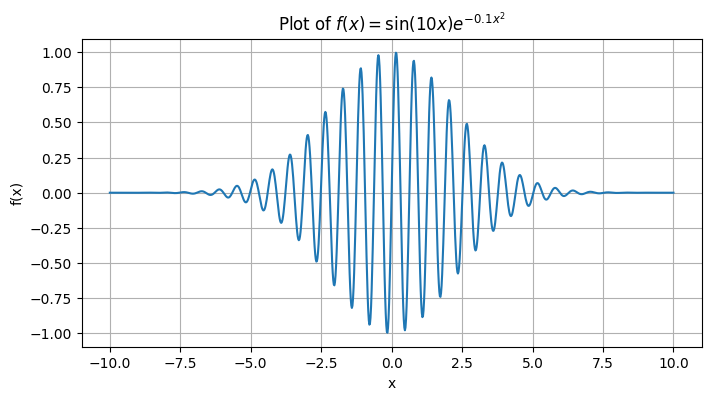

In [9]:
# Par 1: plot of f(x)
import numpy as np
import matplotlib.pyplot as plt

def plot_fx(x_min=-5, x_max=5, a=0.1, b=10, num_points=1000):

    x = np.linspace(x_min, x_max, num_points)
    y = f(x, a=a, b=b) #Using the function f defined above
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(fr'Plot of $ f(x) = \sin({b}x) e^{{-{a} x^2}}$')
    plt.grid(True)
    plt.show()

# Plot f(x) in the range [-10, 10]
plot_fx(x_min=-10, x_max=10)


***

**Part 2.**

The analytical derivative of $f(x)$ is

$$f^\prime(x) =b \cos(bx)\cdot e^{-ax^2} - 2ax\sin(bx)\cdot e^{-ax^2}\hspace{35pt}\text{(2)}$$

* Write a Python function that calculates the derivative defined in equation ([2](#eq:p1:ana)) (*not* the numerical derivative)

***
**Answer Part 2**

In [ ]:
# Part 2: derivative of the function

def fd(x, a=0.1, b=10):
    
    return b * np.cos(b * x) * np.exp(-a * x**2) - 2 * a * x * np.sin(b * x) * np.exp(-a * x**2)

***

**Part 3.**

Next, you are going to write a Python function that calculates the numerical
derivative of an *arbitrary* single-variable function `f` at a point $x$
using finite differences.

* Write a Python function that calculates the derivative of an arbitrary function using the *forward difference* method (see section 3.3 in [[Hiorth, 2024]](#hiorth) ).

* Apply your function to the particular case of equation ([1](#eq:p1:f)) and $x=1$. Use a suitable value of $h$, e.g. $h=1e-2$, and check that your estimate agrees reasonably well with the *analytical solution*.

Hint: Check out some tips in Appendix A, we would recommend to use the [args](https://realpython.com/python-kwargs-and-args/) possibility in Python to write a numerical derivative function. See also section 1.3.4 in [[Hiorth, 2024]](#hiorth).

***
**Answer Part 3**  
The forward difference method is usually $ f'(x) = \frac{f(x + h) - f(x)}{h} - \frac{1}{2} f''(\eta) h $. Implementing this into python.

In [18]:
# Part 3 here
import numpy as np

def arb_func(x): # An arbitrary function, can be changed when calling fw_diff.
    return np.sin(x)

def fw_diff(f = arb_func, x=0, h=1e-2): #Forward difference method, with error handling.
    if f is None:
        raise ValueError("You must provide a function f.")
    if not callable(f):
        raise TypeError("The first argument must be a callable function.")
    if h <= 0:
        raise ValueError("Step size h must be a positive number.")

    try:
        return (f(x + h) - f(x)) / h
    except Exception as e:
        raise RuntimeError(f"An error occurred while evaluating the function: {e}")
    
# Example usage:
x_value = np.pi/4
true_value = np.cos(x_value) # The true derivative of sin(x) is cos(x)
print(f"Forward difference approximation of f' at x={x_value}: {fw_diff(f=arb_func, x=x_value)}. True value: {true_value}")

Forward difference approximation of f' at x=0.7853981633974483: 0.7035594916892096. True value: 0.7071067811865476


Implementing for function $(1)$, which is defined as f in earlier code.

**Part 4.**

* Write another Python function that calculates $f^{\prime}(x)$ with the *central difference* method (see section 3.4 in [[Hiorth, 2024]](#hiorth)).

In [ ]:
# Part 4 here

**Part 5.**

Next, we wish to quantify the error in our numerical derivative approximations for the point $x=1$.

* For each of the two derivative approximations to $f^{\prime}(1)$ (forward difference and central difference), make a scatter plot that shows the *absolute error* of the approximation on the $y$-axis versus the step size, $h$, on the $x$-axis. Include both error curves in the same figure. The step sizes should be varied logarithmically between $h=10^{-16}$ and $h=10^0=1$.

* Comment on what you observe in the figure you made. When is the numerical error smallest, and why? Is it what you expect from a theoretical analysis using Taylor's formula?

In [ ]:
# Part 5 here

# 4. Exercise 3, Part II: FD with Classes
<div id="exer:fd_classes"></div>

Implementing numerical algorithms with free functions, as we did in the
previous exercise, is perfectly fine, and you can complete the course by only
coding in this way. However, experience has taught us that it is easy to
introduce unnecessary errors when using this approach. In many cases you
are better off by also using classes, and maybe [object-oriented design](https://realpython.com/python3-object-oriented-programming/).
In this exercise, you will get some practice in coding with classes.
This knowledge will come in handy in later projects, and in any case
it is a good tool to have in your programming toolkit.

Previously, we worked with a function having two input parameters, $a$ and $b$.
Implementing numerical algorithms using free functions was then simple.
However, in a more complicated situation there
could be dozens, or even hundreds, of parameters to keep track of.
Most of these parameters might have fixed values, but frequently you will
want to re-run a model with slightly different parameters than before.
If you are not using classes, it is very easy to use the wrong parameters.
This is especially true when working in a Jupyter notebook, because then it is
possible to run code blocks in any order. If you forget to excute a cell that is
responsible for updating one of your variables, your subsequent calculations
might use incorrect input, and thus end up being wrong!

**Key take-away: Classes provide encapsulation.**

By wrapping parts of your code into classes, and particular realizations of
classes (objects), you facilitate code re-use, and it can make your code
easier to understand and work with, thus reducing the probability of
introducing bugs which may be hard to track down.



## 4.1 A Crash Course on Classes
<div id="exer:crash_course"></div>

To get started, there are really only a couple of things you need to know.
First, all of your classes should include a special function called `__init__`,
in which you declare the variables (attributes) you wish an instance / object
of the class to keep track of.

Second, when setting, updating, or fetching attributes stored within the class,
you should always use the prefix `self`, followed by a dot.
Furthermore, the functions you define inside the class should have `self` as
the first function argument ([there are exceptions](https://realpython.com/python3-object-oriented-programming/),
but we will not consider that in this project).
All of this is best understood via an example:

In [ ]:
import matplotlib.pyplot as plt

class WavePacket:
    """
    A class representation of a wave packet-function.
    """
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def f(self, x):
        return np.sin(self.b*x)*np.exp(-self.a*x*x)

    def plot(self, x_min=-10, x_max=10, dx=0.01):
        """
        A simple plotting routine for plotting f(x) in some range.
        """
        x = np.arange(x_min, x_max, dx)
        y = self.f(x)
        fig = plt.figure()
        plt.plot(x, y)
        plt.grid()

Besides the initialization method and a function that calculates $f(x)$ from
equation ([1](#eq:p1:f)), the class includes a simple plotting routine.
A major difference from before is the following: when our function $f(x)$
is defined inside a class, we do not have to pass around $a$ and $b$ as
arguments to the function `f`. Instead, we simply access $a$ and $b$ from
inside the class itself (using the `self`-prefix).
<!--  -->
<!-- both when referring to the variables / attributes, and as the first input -->
<!-- argument to the function. -->

Below is an example of how to use the class:

In [ ]:
# Create two WavePacket objects, having their own parameter values
WP1 = WavePacket(0.1, 2)  # a=0.1, b=2
WP2 = WavePacket(0.1, 10)  # a = 0.1, b=10

# Evaluate the two functions at a specific point
x = 1
print(WP1.f(x))
print(WP2.f(x))

# Plot the two functions
WP1.plot()
WP2.plot()

Although we had to write slightly more code, we hope you appreciate
how easy this makes running parallel simulations with different parameters.
Actually, Python provides a way for us to simplify even further, by
defining the special [`__call__`](https://www.realpythonproject.com/python-magic-oop-dunder/)  method for the class:

In [ ]:
class FancyWavePacket:
    """
    A slightly more fancy class representation of a wave packet-function.

    In this version, we define the dunder (double-underscore) method __call__,
    which lets us treat objects of the class as if they were real functions!
    """
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __call__(self, x):
        return np.sin(self.b*x)*np.exp(-self.a*x*x)

Compared to the first example of the class, observe that we have replaced the
function `f` by `__call__` (with two underscores on both sides of "call").
This way, we we can write our code *as if FancyWavePacket was a function*:

In [ ]:
WP1 = FancyWavePacket(0.1, 2)  # a=0.1, b=2
WP2 = FancyWavePacket(0.1, 10)  # a = 0.1, b=10

# Evaluate the two functions at a specific point
x = 1
print(WP1(x))  # If WP1 had been a function, the syntax would be the same here!
print(WP2(x))  # Again, we no longer have to type "WP2.f(x)", we can do "WP2(x)".

**READ THIS BEFORE ANSWERING THE EXERCISES BELOW.**

To avoid code duplication, you should only submit a single version of the
WavePacket class. In other words, while different exercises will ask you to add
a new function to the class, your final delivery should only include the full
class which contains all of the functions.



**Part 1.**

* Add a function ([instance method](https://realpython.com/instance-class-and-static-methods-demystified/)) to the class that returns the forward difference approximation to the derivative of the function `f` at a point `x`. Include both `x` and the step-size `h` as input arguments to the function.

* Add another second function which calculates the central difference approximation.

**Part 2.**

* Make a third class function that, for any input $x$, creates scatter plots showing the absolute error of the two finite difference approximations of $f^{\prime}(x)$ versus step size. As before, choose step sizes in the range from $10^{-16}$ to 1 (with logarithmic spacing).

Hint: You should re-use the first two functions when making the third one.

In [ ]:
# Full class here

# 5. Exercise 4: Automatic for the people?
<div id="exer:autoder"></div>

## 5.1 Introduction to automatic differentiation

At the core of computational models, the computer evaluates *gradients*. Gradients may be evaluated using numerical differentiation. Numerical differentiation is usually slow and could be influenced by round off errors. Humans can calculate derivatives of complicated functions using a set of rules. Why cannot the computer do the same, provided of course that we explain the rules? This idea was explored by Wengert in 1964 [[wengert1964simple]](#wengert1964simple). 

The core idea behind automatic differentiation is the fact that when we evaluate a function, it is done by using a set of fixed operations: addition, subtraction, multiplication, division and a set of elementary functions, $\sin, \log, \exp$ etc [[wengert1964simple]](#wengert1964simple).

So how can we tell the algebraic rules of differentiation to the computer? We will do this using Python and object oriented programming. We want to calculate both the function value *and* the derivative at the same time. To achieve this we implement these operations using a vector of size 2

$$\begin{pmatrix}
f(x) \\ f^\prime(x)
\end{pmatrix}\hspace{35pt}\text{(3)}$$

At the top we have the function and at the bottom we have the derivative of the function. First we start by constructing a class

In [ ]:
class duple:
    '''
    Class for automatic differentiation
    top: function value
    bottom: derivative of function 
    '''
    def __init__(self,top, bottom=0):
        self.top = top
        self.bottom = bottom

## 5.2 Addition and substraction
Next, we want to implement some simple operations, lets say we want to do

In [ ]:
x=duple(1,2) #f(x)=1, f'(x)=2
y=duple(3,4) #g(x)=3, g'(x)=4
x+y # f(x)+g(x)=4, f'(x)+g'(x)=6

clearly we want to have as output `[4,6]`. If you run the code, Python will give an error message `TypeError: unsupported operand type(s) for +: 'duple' and 'duple'`. This is because `duple` is a class we have defined,  and the `+` operator is not defined for this class. However, in Python you can implement these operations using [*operator overloading*](https://www.geeksforgeeks.org/operator-overloading-in-python/)

In [ ]:
class duple:
    '''
    Class for automatic differentiation
    top: function value
    bottom: derivative of function 
    '''
    def __init__(self,top, bottom=0):
        self.top = top
        self.bottom = bottom 
    
    def __add__(self, d): # u+v, u'+v' 
        return duple(self.top + d.top, self.bottom + d.bottom )

it is now possible to run the following code

In [ ]:
x=duple(1,2)
y=duple(3,4)
z=x+y
print(z.top, z.bottom)

to get the expected result. It would also be nice to simply do `print(x+y)` or `x+y` and get the result `[4,6]`, instead of accessing variables by e.g. `z.top`. Fortunately Python has functionality for this, `__repr__` and `__str__`. The `__repr__` and `__str__` is what is produced if you simply write `x+y` or `print(x+y)` in the terminal respectively. 

**Part 1.**
* add the following functions to your class, what happens when you do `x+y`?

In [ ]:
def __repr__(self):
        return "["+str(self.top)+","+str(self.bottom)+"]"
    
def __str__(self):
        return "["+str(self.top)+","+str(self.bottom)+"]"

will allow you to get nice formatted output.

**Part 2.**

In the code above we have implemented `+` operator, however if you try to execute `+x` or `-x`, Python will give an error message `TypeError: bad operand type for unary -: 'duple'`.

* Extend your code to make it possible to perform those operations. (Hint: check out `__neg__` and `__pos__` in the [documentation](https://docs.python.org/3/library/operator.html))

* Implement the `-` operator using `__sub__`, test that if you do `x-y` you get `[-2,-2]`

In [ ]:
# Part 2 here

## 5.3 Multiplication and division
So far we have treated the function (top) and derivative (bottom) equally in terms of addition and subtraction. That is because addition and subtraction is a linear operation, i.e. $(f(x)+g(x))^\prime=f^\prime(x)+g^\prime(x)$. For multiplication and division we have different rules

$$(f(x)\cdot g(x))^\prime =f^\prime(x)\cdot g(x)+f(x)\cdot g^\prime(x)\hspace{35pt}\text{(4)}$$

$$\left(\frac{f(x)}{g(x)}\right)^\prime =\frac{f^\prime(x)\cdot g(x)-f(x)\cdot g^\prime(x)}{g(x)^2}\hspace{35pt}\text{(5)}$$

Hence we need to implement a different rule for the multiplication operator

**Part 3.**
1. use the `__mul__` function to implement the `*` operator, use normal multiplication for the top, and equation ([11](#eq:auto:mul)) for the bottom.

2. use the `__truediv__` function to implement the `/` operator, use normal division for the top, and equation ([12](#eq:auto:div)) for the bottom.

### Test of code

Before proceeding to more advanced functions, we can actually do quite a lot with our small code and calculate derivatives of simple functions

In [ ]:
x=1.2 # just for making it easy to use other values
One=duple(1.,0.) # derivative of a constant is zero
X=duple(x,1) # derivative of x with respect to x is 1
print("auto diff=",X*X*X)
print("analytical=",x*x*x, 3*x*x)

print("auto diff=", One/(One+X))
print("analytical=", 1/(1+x),-1/(1+x)**2)

Exp=duple(np.exp(x),np.exp(x)) # derivative of exp(x) is exp(x)
Sin=duple(np.sin(x),np.cos(x)) # derivative of sin(x) is cos(x)
print("auto diff=", Exp*Sin)
print("analytical=", np.exp(x)*np.sin(x), np.exp(x)*np.sin(x)+np.exp(x)*np.cos(x))

## 5.4 Adding more functions
So far we have only implemented functions where we explicitly know the derivative, but it would be more convenient if we could implement more complicated functions, such as $\ln(1+e^x)$, without explicitly calculating the derivatives. Actually the only thing we need to do is to implement the kernel rule for the bottom part

$$f(g(x))^\prime=f^\prime(g(x))\cdot g^\prime (x)\hspace{35pt}\text{(6)}$$

**Part 4.**
Finish the code below

In [ ]:
class dfunction:
    
    def __init__(self, f, df):
        self.f = f
        self.df = df

    def __call__(self,d: duple): # kernel rule sending in and returning duple
        return duple(self.f(d.top), #fill inn kernel rule here!)


If your code works, you should be able to run the following code

In [ ]:
def f(x):
    return np.log(x)
def df(x):
    return 1/x

x=3.1
One=duple(1.,0.) # derivative of a constant is zero
X=duple(x,1) # derivative of x with respect to x is 1
Log=dfunction(f,df) #note no arguments to f - we are passing the function
Exp=dfunction(np.exp,np.exp) # same here
print("auto diff ", Log(One+Exp(X)))
print("analytical ", np.log(1+np.exp(x)),np.exp(x)/(1+np.exp(x)))

Next, we can easily evaluate the function that we evaluated previously using finite differences

In [ ]:
a=0.1
b=10
x=1
A=duple(a) #second argument is default 0 i.e. a constant
B=duple(b) #second argument is default 0 i.e. a constant
X=duple(x,1)
print('auto diff ', Sin(B*X)*Exp(-A*X*X))
print('analytical ', np.sin(b*x)*np.exp(-a*x*x),b*np.cos(b*x)*np.exp(-a*x*x)-2*a*x*np.sin(b*x)*np.exp(-a*x*x))

**Part 5.**
* Write a few sentences about the use of automatic differentiation in some areas

* Make some comments about the strength and weaknesses of automatic differentiation compared to numerical differentiation

# Appendix A: Passing arguments to functions
In this project one of the tasks is to write a function that can calculate the numerical derivative of a function that needs two additional parameters (`a` and `b`) to be evaluated (see equation ([1](#eq:p1:f))). Let us first take a look on how the call signature would be i `f` only depends on $x$ (i.e. if `a` and `b` was fixed), this is extremely easy:
we can  simply take  `f`, `x`, and `h` (or $\Delta x$) (step-size) as input arguments
to our derivative function. Assuming it is called `calc_derivative`,
it could work something like this:

In [ ]:
df_x = calc_derivative(f, x=1.0, h=1.0e-3)

However, the function in equation ([1](#eq:p1:f)) depends on two additional
input parameters, `a` and `b`. We can of course add these two as extra
arguments to the derivative function, but then we would lose generality,
for not every function has the same two parameters. One way out of this
dilemma could be to create a new function for each combination of
`a` and `b` that you use, for example:

In [ ]:
def one_version_of_f(x):
    """
    The function f(x) = sin(10x) * exp(-0.1x^2).
    """
    return f(x, 0.1, 10.0)

def another_version_of_f(x):
    """
    The function f(x) = sin(3.14x) * exp(-0.5x^2).
    """
    return f(x, 0.5, 3.14)

Since both of these example functions have their own values for `a` and `b` hard-coded
inside them, we do not need to pass anything extra to `calc_derivative`, that is,
we can do:

In [ ]:
df1_x = calc_derivative(one_version_of_f, x=1.0, h=1.0e-3)
df2_x = calc_derivative(another_version_of_f, x=1.0, h=1.0e-3)

Another possibility is to use the the [args](https://realpython.com/python-kwargs-and-args/) mechanism,
which lets you pass around a variable number of parameters to a function.
An example of how this works is:

In [ ]:
def calc_derivative(f, x, h, *args):
    return (f(x, *args) - f(x-h, *args))/h

If you use this method, you need to pass the values of `a` and `b` to the
function that calculates the derivative, e.g.:

In [ ]:
calc_derivative(f, x=1.0, h=1.0e-3, a=0.1, b=10.0)
calc_derivative(another_version_of_f, x=1.0, h=1.0e-3, a=0.5, b=3.14)

# Guidelines for project submission

You should bear the following points in mind when working on the project:
* Write the name of all persons working in the group at the top of the notebook.

* The final project report must start with an abstract, the abstract is a self contained summary of the project and should contain quantitative statements. 

* Start your notebook by providing a short introduction in which you outline the nature of the problem(s) to be investigated.

* End your notebook with a brief summary of what you feel you learned from the project (if anything). Also, if you have any general comments or suggestions for what could be improved in future assignments, this is the place to do it.

* All code that you make use of should be present in the notebook, and it should ideally execute without any errors (especially run-time errors). If you are not able to fix everything before the deadline, you should give your best understanding of what is not working, and how you might go about fixing it.

* Avoid duplicating code! If you find yourself copying and pasting a lot of code, it is a strong indication that you should define reuseable functions and/or classes.

* If you use an algorithm that is not fully described in the assignment text, you should try to explain it in your own words. This also applies if the method is described elsewhere in the course material.

* In some cases it may suffice to explain your work via comments in the code itself, but other times you might want to include a more elaborate explanation in terms of, e.g., mathematics and/or pseudocode.

* In general, it is a good habit to comment your code (though it can be overdone).

* When working with approximate solutions to equations, it is very useful to check your results against known exact (analytical) solutions, should they be available.

* It is also a good test of a model implementation to study what happens at known 'edge cases'.

* Any figures you include should be easily understandable. You should label axes appropriately, and depending on the problem, include other legends etc. Also, you should discuss your figures in the main text.

* It is always good if you can reflect a little bit around *why* you see what you see.

# Bibliography
1. <div id="goldberg1991every"></div> **D. Goldberg**.  What Every Computer Scientist Should Know About Floating-Point Arithmetic, *ACM computing surveys (CSUR)*, 23(1), pp. 5-48, 1991.

2. <div id="fretwell2013bedmap2"></div> **P. Fretwell, H. D. Pritchard, D. G. Vaughan, J. L. Bamber, N. E. Barrand, R. Bell, C. Bianchi, R. Bingham, D. D. Blankenship and G. Casassa**.  Bedmap2: Improved Ice Bed, Surface and Thickness Datasets for Antarctica, *The Cryosphere*, 7(1), pp. 375-393, 2013.

3. <div id="wengert1964simple"></div> **R. E. Wengert**.  A Simple Automatic Derivative Evaluation Program, *Communications of the ACM*, 7(8), pp. 463-464, 1964.

4. <div id="hiorth"></div> **A. Hiorth**.  *Computational Engineering and Modeling*, https://github.com/ahiorth/CompEngineering, 2021.

5. <div id="IPCC2021"></div> **V. Masson-Delmotte, P. Zhai, A. Pirani, S. L. Connors, C. Pean, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M. I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J. B. R. Matthews, T. K. Maycock, T. Waterfield, O. Yelekci, R. Yu and B. Z. (eds.)**.  Climate Change 2021: the Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change, *Cambridge University Press. In Press.*, 2021.

6. <div id="thyng2016true"></div> **K. M. Thyng, C. A. Greene, R. D. Hetland, H. M. Zimmerle and S. F. DiMarco**.  True Colors of Oceanography: Guidelines for Effective and Accurate Colormap Selection, *Oceanography*, 29(3), pp. 9-13, 2016.

7. <div id="noerdlinger2007melting"></div> **P. D. Noerdlinger and K. R. Brower**.  The Melting of Floating Ice Raises the Ocean Level, *Geophysical Journal International*, 170(1), pp. 145-150, 2007.